# Исследование поведения пользователей мобильного приложения

**Цель исследования**

Цель данного проекта состоит в том, чтобы разобраться, как ведут себя пользователи нашего мобильного приложения. Мы изучим воронку продаж и исследуем результаты A/A/B-эксперимента, цель которого оценить влияние нового шрифта в приложении. 


**Описание данных**

Данные представлены логом logs_exp.csv.

Структура logs_exp.csv:
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**План исследования**

1. Загрузка данных.

Загрузим данные, изучим общую информацию о них. 

2. Предобработка данных.

Проведем предобработку данных. 

3. Изучение и проверка данных.

Определим количество пользователей и событий в логе, проверим полноту данных. 

4. Изучение воронки событий.

Выстроим воронку событий, определим на каком этапе теряется больше всего пользователей.

5. Изучение результатов эксперимента.

Проверим, находят ли статистические критерии разницу между выборками. Подведем итоги эксперимента.

6. Выводы

Подведем итоги исследования.

### Загрузим данные и изучим общую информацию о них 

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропуски в данных отсутствуют, формат данных корректен. Требуется скорректировать наименования столбцов и проверить данные на наличие дубликатов.

### Проведем предобработку данных.  

#### Скорректируем наименования столбцов.

In [5]:
data.columns = ['event', 'device_id', 'timestamp', 'group']

#### Проверим данные на наличие дубликатов.

In [6]:
print('Число полных дубликатов:', data.duplicated().sum())

Число полных дубликатов: 413


Удалим дубликаты.

In [7]:
data = data.drop_duplicates()

In [8]:
print('Число полных дубликатов:', data.duplicated().sum())

Число полных дубликатов: 0


Проверим данные на наличие неявных дубликатов.

In [9]:
data['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Неявных дубликатов не обнаружено.

#### Добавим столбец даты и времени и столбец дат.

In [10]:
data['date_time'] = pd.to_datetime(data['timestamp'], unit='s')

In [11]:
data['date'] = data['date_time'].dt.floor('d')

#### Проверим нет ли пользователей, попавших в несколько групп.

In [12]:
group_a1 = data[data['group'] == 246]
group_a2 = data[data['group'] == 247]
group_b = data[data['group'] == 248]
wrong_users = group_a1[group_a1['device_id'].isin(group_a2['device_id'])]['device_id'].unique()
print(f'Число совпадений пользователей в группах А1 и А2: {wrong_users.size}')

Число совпадений пользователей в группах А1 и А2: 0


In [13]:
wrong_users = group_a1[group_a1['device_id'].isin(group_b['device_id'])]['device_id'].unique()
print(f'Число совпадений пользователей в группах А1 и В: {wrong_users.size}')

Число совпадений пользователей в группах А1 и В: 0


In [14]:
wrong_users = group_a2[group_a2['device_id'].isin(group_b['device_id'])]['device_id'].unique()
print(f'Число совпадений пользователей в группах А2 и В: {wrong_users.size}')

Число совпадений пользователей в группах А2 и В: 0


Совпадений в группах не обнаружено.

Дубликаты удалены, названия столбцов скорректированы, добавлены новые столбцы. Предобработка завершена.

### Изучим и проверим данные.  

#### Посчитаем сколько всего событий в логе.

In [15]:
print('Событий всего:', data['event'].count())

Событий всего: 243713


#### Посчитаем сколько всего пользователей в логе.

In [16]:
print('Пользователей всего:',data['device_id'].nunique())

Пользователей всего: 7551


#### Посчитаем сколько в среднем событий приходится на пользователя.

In [17]:
print('В среднем событий на пользователя:', round(data['event'].count()/data['device_id'].nunique(), 1))

В среднем событий на пользователя: 32.3


Оценим влияние выбросов

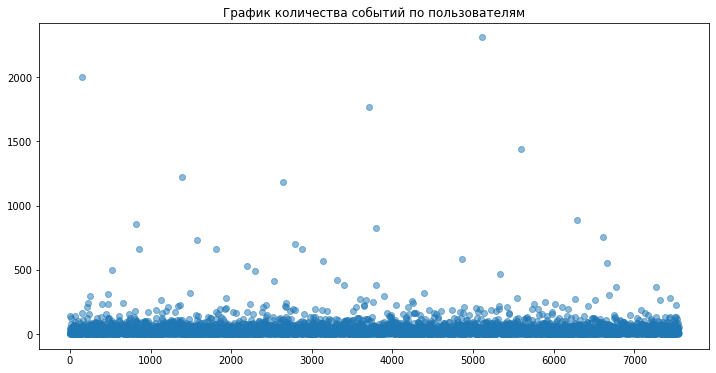

In [18]:
events_by_users = data.groupby('device_id', as_index=False).agg({'event': 'count'})

# серия из чисел от 0 до количества наблюдений в events_by_users
x_values = pd.Series(range(0, len(events_by_users)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, events_by_users['event'], alpha=0.5) 
plt.title('График количества событий по пользователям')
plt.show()

In [19]:
percentile = np.percentile(events_by_users['event'], [95, 99])
print(f'95-й перцентиль: {percentile[0]}, 99-й перцентиль: {percentile[1]}')

95-й перцентиль: 89.0, 99-й перцентиль: 200.5


95% пользователей совершают не более 89 событий, пересчитаем с учетом этого среднее число событий на пользователя.

In [20]:
print('В среднем событий на пользователя:', round(events_by_users.query('event <= 89')['event'].mean(), 1))

В среднем событий на пользователя: 24.1


#### Определим данными за какой период мы располагаем.

Найдем максимальную и минимальную дату.

In [21]:
print('Минимальная дата', data['date'].min())
print('Максимальная дата', data['date'].max())

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


Рассмотрим как события распределены по дням.

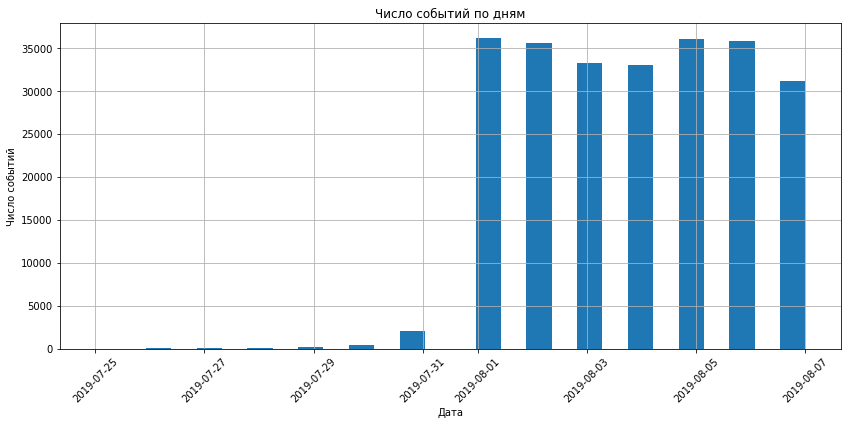

In [22]:
plt.figure(figsize=(14,6))
data['date'].hist(bins = 28)
plt.xticks(rotation= 45)
plt.ylabel('Число событий')
plt.xlabel('Дата')
plt.title('Число событий по дням')
plt.show()

Число событий значительно растет после 1 августа. Можно утверждать, что мы имеем полные данные только за период с 1 по 7 августа. Отбросим данные за предыдущие даты, чтобы они не вносили искажений.

In [23]:
data_filt = data.query('date > "2019-07-31"')

#### Проверим сколько событий и пользователей мы потеряли.

In [24]:
print('Пользователей потеряно: {} ({}%)'.format(
    data['device_id'].nunique() - data_filt['device_id'].nunique(),
    round((data['device_id'].nunique() - data_filt['device_id'].nunique()) / data['device_id'].nunique() * 100, 1)))

Пользователей потеряно: 17 (0.2%)


In [25]:
print('Событий потеряно: {} ({}%)'.format(
    data['event'].count() - data_filt['event'].count(),
    round((data['event'].count() - data_filt['event'].count()) / data['event'].count() * 100, 1)))

Событий потеряно: 2826 (1.2%)


#### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [26]:
data_groups = data_filt.groupby('group').agg({'device_id': 'nunique'})
data_groups

,device_id
group,
246,2484
247,2513
248,2537


### Изучим воронку событий.  

#### Посмотрим, какие события есть в логах и как часто они встречаются.

In [27]:
data_filt['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

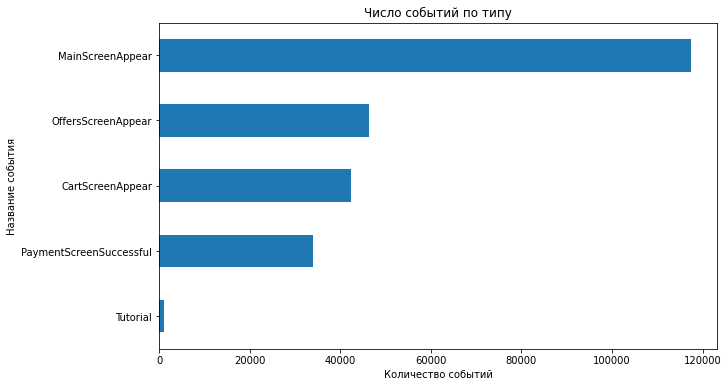

In [28]:
(data_filt['event'].value_counts(ascending = True)
 .plot(kind='barh', figsize=(10, 6), title='Число событий по типу', grid=False))
plt.xlabel('Количество событий')
plt.ylabel('Название события')
plt.show()

Чаще всего встречается событие MainScreenAppear, реже всего - Tutorial.

#### Посчитаем, сколько пользователей совершали каждое из этих событий и найдем долю пользователей, которые хоть раз совершали событие.

In [29]:
event_grouped = (
    data_filt.groupby('event', as_index=False)
    .agg({'device_id': 'nunique'})
    .sort_values('device_id', ascending=False))
event_grouped.columns = ['event', 'user_count']
event_grouped['user_portion']  = round(event_grouped['user_count'] / data_filt['device_id'].nunique() * 100, 1)
event_grouped

,event,user_count,user_portion
1,MainScreenAppear,7419,98.5
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


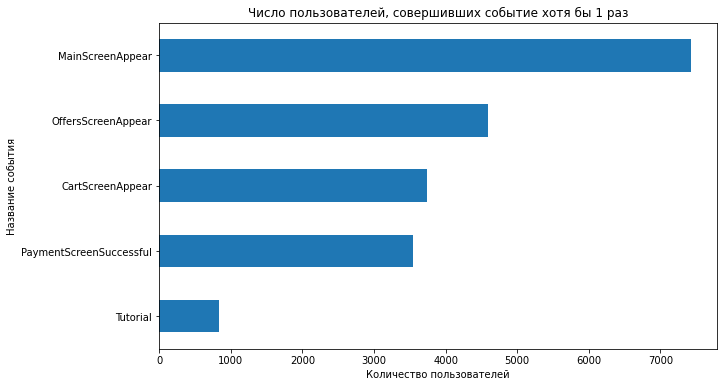

In [30]:
(data_filt.groupby('event')
 .agg({'device_id': 'nunique'})
 .sort_values('device_id', ascending=True)
 .plot(kind='barh', figsize=(10, 6), title='Число пользователей, совершивших событие хотя бы 1 раз', grid=False, legend=False))
plt.xlabel('Количество пользователей')
plt.ylabel('Название события')
plt.show()

#### Определим в каком порядке происходят события.

Можно предположить, что воронка событий выглядит следующим образом: MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful. Событие Tutorial	- обучение, не обязательно для совершения покупки, соответственно при расчете воронки его учитывать не будем.

In [31]:
event_grouped = event_grouped[event_grouped['event'] != 'Tutorial']
event_grouped

,event,user_count,user_portion
1,MainScreenAppear,7419,98.5
2,OffersScreenAppear,4593,61.0
0,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0


#### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.

In [32]:
event_grouped['conversion'] = round(
    event_grouped['user_count'] / event_grouped['user_count'].shift(1, fill_value=7419) * 100, 1)
event_grouped['user_loses'] = event_grouped['user_count'].shift(1, fill_value=7419) - event_grouped['user_count']
event_grouped

,event,user_count,user_portion,conversion,user_loses
1,MainScreenAppear,7419,98.5,100.0,0
2,OffersScreenAppear,4593,61.0,61.9,2826
0,CartScreenAppear,3734,49.6,81.3,859
3,PaymentScreenSuccessful,3539,47.0,94.8,195


Больше всего пользователей теряется при переходе от события MainScreenAppear к событию OffersScreenAppear - только 61.9% пользователей перешли от MainScreenAppear к OffersScreenAppear. На других этапах потери меньше: 81.3% пользователей перешли от OffersScreenAppear к CartScreenAppear и 94.8% пользователей перешли от CartScreenAppear к PaymentScreenSuccessful. 

#### Посчитаем какая доля пользователей доходит от первого события до оплаты.

In [33]:
print('Доля пользователей, дошедших от первого события до оплаты: {}%'.format(
    round(event_grouped['user_count'][3] / event_grouped['user_count'][1] * 100, 1)))

Доля пользователей, дошедших от первого события до оплаты: 47.7%


### Изучим результаты эксперимента.

#### Посмотрим количество пользователей в каждой экспериментальной группе

In [34]:
data_groups

,device_id
group,
246,2484
247,2513
248,2537


#### Проверим, находят ли статистические критерии разницу между выборками 246 и 247 - контрольными группами для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп.

In [35]:
data_pivot = data_filt.pivot_table(index='group',columns = 'event', values='device_id',aggfunc='nunique')
data_pivot['total'] = data_groups['device_id']
data_pivot = data_pivot.drop('Tutorial', axis=1)
data_pivot

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
group,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


Добавим объединённую контрольную группу 249, состоящую из групп 246 и 247.

In [36]:
data_pivot.loc[249] = data_pivot.loc[246] + data_pivot.loc[247]
data_pivot

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total
group,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


Посчитаем число пользователей, совершивших наиболее популярное событие (MainScreenAppear) в контрольных группах 246 и 247.

In [37]:
data_pivot.loc[[246, 247]]['MainScreenAppear']

group
246    2450
247    2476
Name: MainScreenAppear, dtype: int64

Посчитаем долю пользователей, совершивших это событие.

In [38]:
round(data_pivot.loc[[246, 247]]['MainScreenAppear'] / data_pivot.loc[[246, 247]]['total'] * 100, 1)

group
246    98.6
247    98.5
dtype: float64

Проверим, будет ли отличие между группами статистически достоверным.

Напишем функцию для проверки гипотез.

In [39]:
def test(success_1, success_2, trials_1, trials_2, alpha):  
        
    p1 = success_1/trials_1

    # пропорция успехов во второй группе:
    p2 = success_2/trials_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (success_1 + success_2) / (trials_1 + trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # посчитаем, как далеко статистика уехала от нуля, так как распределение статистики нормальное, вызовем метод cdf() 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница'
        )

Так как нам требуется решить задачу сравнения пропорций двух генеральных совокупностей по выборкам из них, мы будем использовать двухпропорционный Z-тест.

H0: доли уникальных посетителей, побывавших на данном этапе воронки, равны. 

H1: между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница.

Примем уровень значимости за 0.05.

In [40]:
test(data_pivot.loc[246][1], data_pivot.loc[247][1], data_pivot.loc[246][4], data_pivot.loc[247][4], 0.05)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница


Напишем функцию для проверки гипотез по всем событиям.

In [41]:
def events_test(group_1, group_2, alpha):  
    print(f'Результат проверки гипотез для события MainScreenAppear в группах {group_1} и {group_2}')
    test(data_pivot.loc[group_1][1], data_pivot.loc[group_2][1], data_pivot.loc[group_1][4], data_pivot.loc[group_2][4], alpha)
    print()
    
    print(f'Результат проверки гипотез для события OffersScreenAppear в группах {group_1} и {group_2}')
    test(data_pivot.loc[group_1][2], data_pivot.loc[group_2][2], data_pivot.loc[group_1][4], data_pivot.loc[group_2][4], alpha)
    print()
        
    print(f'Результат проверки гипотез для события CartScreenAppear в группах {group_1} и {group_2}')
    test(data_pivot.loc[group_1][0], data_pivot.loc[group_2][0], data_pivot.loc[group_1][4], data_pivot.loc[group_2][4], alpha)
    print()
    
    print(f'Результат проверки гипотез для события PaymentScreenSuccessful в группах {group_1} и {group_2}')
    test(data_pivot.loc[group_1][3], data_pivot.loc[group_2][3], data_pivot.loc[group_1][4], data_pivot.loc[group_2][4], alpha)

In [42]:
events_test(246, 247, 0.05)

Результат проверки гипотез для события MainScreenAppear в группах 246 и 247
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события OffersScreenAppear в группах 246 и 247
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события CartScreenAppear в группах 246 и 247
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события PaymentScreenSuccessful в группах 246 и 247
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований сч

Не удалось отвергнуть нулевую гипотезу ни по одному из событий - нет оснований считать доли в контрольных группах разными. Можем утверждать, разбиение на группы работает корректно.

#### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Также сравним результаты с объединённой контрольной группой.

In [43]:
events_test(246, 248, 0.05)

Результат проверки гипотез для события MainScreenAppear в группах 246 и 248
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события OffersScreenAppear в группах 246 и 248
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события CartScreenAppear в группах 246 и 248
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события PaymentScreenSuccessful в группах 246 и 248
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований сч

In [44]:
events_test(247, 248, 0.05)

Результат проверки гипотез для события MainScreenAppear в группах 247 и 248
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события OffersScreenAppear в группах 247 и 248
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события CartScreenAppear в группах 247 и 248
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события PaymentScreenSuccessful в группах 247 и 248
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований счит

In [45]:
events_test(249, 248, 0.05)

Результат проверки гипотез для события MainScreenAppear в группах 249 и 248
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события OffersScreenAppear в группах 249 и 248
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события CartScreenAppear в группах 249 и 248
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что между долями уникальных посетителей, побывавших на данном этапе воронки, есть значимая разница

Результат проверки гипотез для события PaymentScreenSuccessful в группах 249 и 248
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований с

**Ни в одном из тестов не удалось отвергнуть нулевую гипотезу. Можно утверждать, что изменение шрифта не привело ухудшению продажах. Тест можно считать оконченным.**

#### Проведем коррекцию уровня значимости методом Холма.

Для каждой пары выборок мы проводили 4 теста - для 4-х событий. Проведем коррекцию уровня значимости методом Холма.

In [46]:
# Модифицируем тест
def test_mod(success_1, success_2, trials_1, trials_2, alpha):  
        
    p1 = success_1/trials_1

    # пропорция успехов во второй группе:
    p2 = success_2/trials_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (success_1 + success_2) / (trials_1 + trials_2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # посчитаем, как далеко статистика уехала от нуля, так как распределение статистики нормальное, вызовем метод cdf() 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

Напишем функцию для вывода таблицы со значениями теста до и после применения метода Холма.

In [47]:
def test_corr(g1, g2):
    datas = pd.DataFrame(columns=['p_value', 'alpha'])
    m = 4
    alpha = 0.05
    result = []
    for i in range(m): 
        result += [test_mod(data_pivot.loc[g1][i], data_pivot.loc[g2][i], data_pivot.loc[g1][4], data_pivot.loc[g2][4], alpha)]
    datas['p_value'] = pd.Series(result) 
    datas['alpha'] = 0.05
    datas['test_result'] = datas['p_value'] < datas['alpha']
    result_corr = []
    for i in range(m):  
        result_corr += [alpha / (m - i)]
    datas['alpha_holm'] = pd.Series(result_corr) 
    datas['test_result_corr'] = datas['p_value'] < datas['alpha_holm']

    return datas

Проводим тестирование для групп 246 и 247

In [48]:
test_corr(246, 247)

,p_value,alpha,test_result,alpha_holm,test_result_corr
0,0.228834,0.05,False,0.012500,False
1,0.757060,0.05,False,0.016667,False
2,0.248095,0.05,False,0.025000,False
3,0.114567,0.05,False,0.050000,False


Проводим тестирование для групп 246 и 248

In [49]:
test_corr(246, 248)

,p_value,alpha,test_result,alpha_holm,test_result_corr
0,0.078429,0.05,False,0.012500,False
1,0.294972,0.05,False,0.016667,False
2,0.208362,0.05,False,0.025000,False
3,0.212255,0.05,False,0.050000,False


Проводим тестирование для групп 247 и 248

In [50]:
test_corr(247, 248)

,p_value,alpha,test_result,alpha_holm,test_result_corr
0,0.578620,0.05,False,0.012500,False
1,0.458705,0.05,False,0.016667,False
2,0.919782,0.05,False,0.025000,False
3,0.737342,0.05,False,0.050000,False


Проводим тестирование для групп 249 и 248

In [51]:
test_corr(249, 248)

,p_value,alpha,test_result,alpha_holm,test_result_corr
0,0.181759,0.05,False,0.012500,False
1,0.294245,0.05,False,0.016667,False
2,0.434255,0.05,False,0.025000,False
3,0.600429,0.05,False,0.050000,False


**После проведения коррекции уровня значимости методом Холма результаты эксперимента не изменились - ни в одном из тестов не удалось отвергнуть нулевую гипотезу. Изменение шрифта не привело к ухудшению продажах.**

### Выводы.

**По результатам исследования было определено следующее:**

По воронке продаж: 
* Воронка продаж состоит из событий MainScreenAppear, OffersScreenAppear, CartScreenAppear и PaymentScreenSuccessful; 
* Больше всего пользователей теряется на событии OffersScreenAppear - только 61.9% пользователей перешли от MainScreenAppear к OffersScreenAppear. На других этапах потери меньше: 81.3% пользователей перешли от OffersScreenAppear к CartScreenAppear и 94.8% пользователей перешли от CartScreenAppear к PaymentScreenSuccessful;
* Доля пользователей, совершивших оплату покупки: 47%;

По результатам А/А/В эксперимента:
* Тест можно считать оконченным. Изменение шрифта не привело ухудшению продажах.